In [1]:
import tifffile as tf
from scipy import ndimage
import numpy as np

import os
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [2]:
fs = 15
resol = 0.0759
c = 'w'
R = 5

wsrc = '../hpcc/clean/'
tsrc = '../hpcc/watershed/'
rsrc = '../hpcc/rotated/'
dst = '../hpcc/watershed/'

struc1 = ndimage.generate_binary_structure(3, 1)
struc2 = ndimage.generate_binary_structure(3, 2)
struc3 = ndimage.generate_binary_structure(3, 3)

ssrange = [50,220,240,260,280,-75]
rrrange = np.linspace(0, 2*np.pi, 100)

Sx = [ np.s_[k,:,:] for k in ssrange ]
Sy = [ np.s_[:,k,:] for k in ssrange ]
Sz = [ np.s_[:,:,k] for k in ssrange ]
Sxyz = Sx + Sy + Sz

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

In [27]:
idname = '2014SBa'

rownum = 5
treenum = 20
nutnum = 7

bname = idname + '_R{}_T{}'.format(rownum, treenum)
print(bname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
    
wdstp = wdst + 'protrusion/'
if not os.path.isdir(wdstp):
    os.makedirs(wdstp)

2014SBa_R5_T20


In [28]:
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

img = tf.imread(wsrc + bname + '/' + fname + '.tif')
tissuefiles = sorted(glob.glob(tsrc + bname + '/' + fname + '_*.tif'))
shell= tf.imread(tissuefiles[2])

distL1 = ndimage.distance_transform_cdt(shell, 'taxicab')
K = np.max(distL1)

2014SBa_R5_T20_007


In [29]:
filename = rsrc + bname + '/' + fname + '_rotation.csv'
data = np.loadtxt(filename, delimiter=',')

wmean = data[0]
rotxyz = data[10:13]
    
bimg = img.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
nutarea = np.sum(border) * (resol ** 2)
border[border > 0] = 1
orig_datapoints = np.asarray(np.nonzero(border))
mcoords = rotxyz @ ((orig_datapoints - wmean.reshape(-1,1))*resol)

In [30]:
PAD = 30

dshell = np.pad(shell, PAD)
dshell = ndimage.binary_dilation(dshell, struc2, PAD-5, border_value=0)

eshell = ndimage.binary_erosion(dshell, struc2, PAD-5, border_value=1)
eshell = eshell[PAD:-PAD, PAD:-PAD, PAD:-PAD]
fshell = wnut.fill_component(eshell)

Closed X
Closed Y
Closed Z


In [43]:
efill = ndimage.binary_erosion(fshell, struc1, 2*K+10)

In [44]:
ishell = efill*shell
ishell, labels, where = wnut.get_largest_element(ishell,1e-3, outlabels=True)
coms = ndimage.center_of_mass(ishell, labels, where)
coms = np.asarray(coms).T

8 components	 1 preserved
[165706    124      4      3      2      2      1      1]


In [45]:
mcoms = rotxyz @ ((coms - wmean.reshape(-1,1))*resol)
mwhere = np.where(np.sqrt((mcoms[1]**2 + mcoms[2]**2)) < R)[0]
nwhere = np.where(np.sqrt((mcoms[1]**2 + mcoms[2]**2)) >= R)[0]
print(len(mwhere))

1


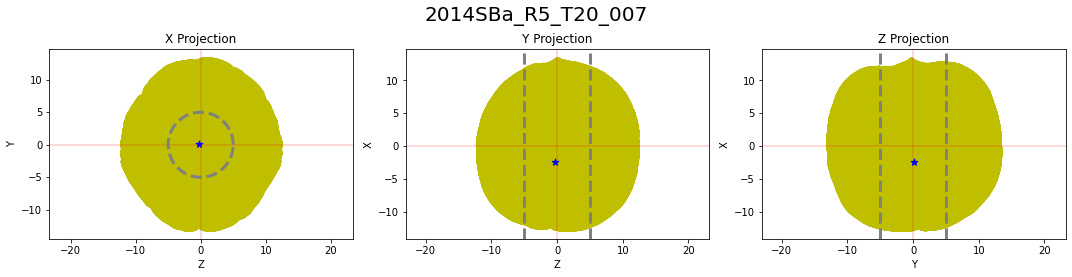

In [46]:
fig, ax = wnut.plot_3Dprojections(mcoords, fname);
ax[0].plot(R*np.cos(rrrange), R*np.sin(rrrange), c='gray', lw=3, ls='--')
ax[1].axvline(R, c='gray', lw=3, ls='--'); ax[1].axvline(-R, c='gray', lw=3, ls='--', zorder=1)
ax[2].axvline(R, c='gray', lw=3, ls='--'); ax[2].axvline(-R, c='gray', lw=3, ls='--', zorder=1)

for i in range(len(mwhere)):
    ax[0].scatter(mcoms[2,mwhere[i]], mcoms[1,mwhere[i]], marker='*', s=50, c='b', alpha=1, zorder=3)
    ax[1].scatter(mcoms[2,mwhere[i]], mcoms[0,mwhere[i]], marker='*', s=50, c='b', alpha=1, zorder=3)
    ax[2].scatter(mcoms[1,mwhere[i]], mcoms[0,mwhere[i]], marker='*', s=50, c='b', alpha=1, zorder=3);
for i in range(len(nwhere)):
    ax[0].scatter(mcoms[2,nwhere[i]], mcoms[1,nwhere[i]], marker='^', s=35, c='r', alpha=1, zorder=2)
    ax[1].scatter(mcoms[2,nwhere[i]], mcoms[0,nwhere[i]], marker='^', s=35, c='r', alpha=1, zorder=2)
    ax[2].scatter(mcoms[1,nwhere[i]], mcoms[0,nwhere[i]], marker='^', s=35, c='r', alpha=1, zorder=2);
filename = wdstp + fname + '_coords'
plt.savefig(filename + '.jpg', dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})

In [47]:
imask = np.zeros_like(shell).astype(np.bool)
for i in where[mwhere]:
    imask[labels == i] = True

imask = ndimage.binary_dilation(imask, struc3, int(np.ceil(K*.1)))
imask = ndimage.binary_dilation(imask, struc1, int(np.ceil(K*.5)))
protruding = shell*imask

In [48]:
efill0 = ndimage.binary_erosion(fshell, struc1, K)
extra = efill0*shell

In [49]:
test = np.zeros_like(shell)
test[shell > 0] += 3
test[extra > 0] += 2
test[protruding > 0] += 4

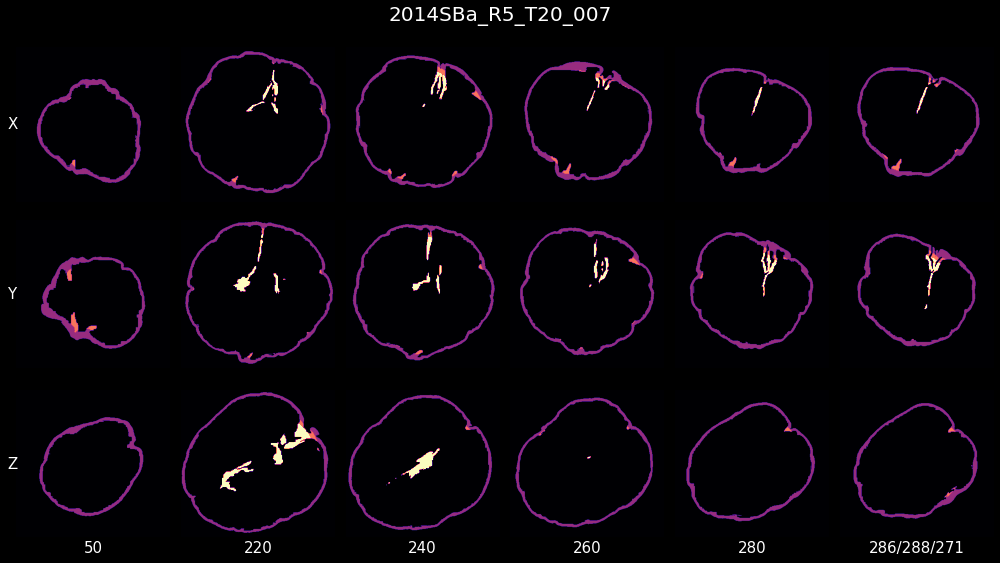

In [50]:
fig, ax = plt.subplots(3,len(ssrange),figsize=(14,8), sharex=False, sharey=False, facecolor='k')
for i in range(3):
    for j in range(len(ssrange)):
        ss = Sxyz[len(ssrange)*i + j]
        ax[i,j].imshow(test[ss], cmap='magma', origin='lower', vmax=7, vmin=0)
        ax[i,j].get_xaxis().set_ticks([])
        ax[i,j].get_yaxis().set_ticks([])
        for spine in ax[i,j].spines.values():
            spine.set_visible(False)
for i,x in enumerate(['X','Y','Z']):
    ax[i,0].set_ylabel(x, fontsize=fs, color=c, rotation='horizontal', ha='center', va='center')
for j in range(len(ssrange)-1):
    ax[-1,j].set_xlabel(ssrange[j], fontsize=fs, color=c)
xlabel = '/'.join((np.asarray(img.shape) + ssrange[-1]).astype(str))
ax[-1,-1].set_xlabel(xlabel, color=c, fontsize=fs)

fig.suptitle(fname, fontsize=fs+5, color=c);
fig.tight_layout()

filename = wdstp + fname + '_protrusion'
plt.savefig(filename + '.jpg', dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})

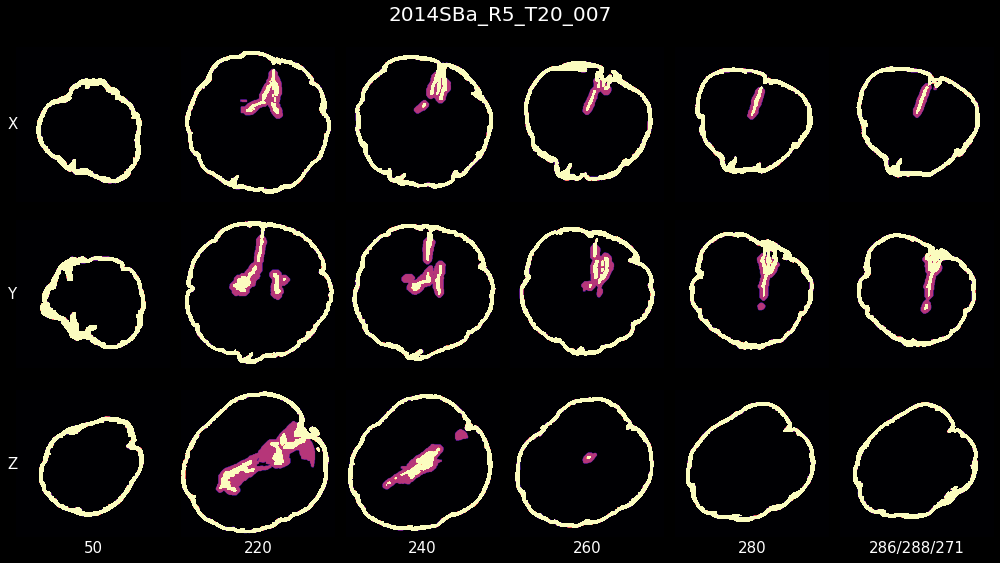

In [51]:
fig, ax = plt.subplots(3,len(ssrange),figsize=(14,8), sharex=False, sharey=False, facecolor='k')
for i in range(3):
    for j in range(len(ssrange)):
        ss = Sxyz[len(ssrange)*i + j]
        ax[i,j].imshow(imask[ss] + shell[ss], cmap='magma', origin='lower', vmax=2, vmin=0)
        ax[i,j].get_xaxis().set_ticks([])
        ax[i,j].get_yaxis().set_ticks([])
        for spine in ax[i,j].spines.values():
            spine.set_visible(False)
for i,x in enumerate(['X','Y','Z']):
    ax[i,0].set_ylabel(x, fontsize=fs, color=c, rotation='horizontal', ha='center', va='center')
for j in range(len(ssrange)-1):
    ax[-1,j].set_xlabel(ssrange[j], fontsize=fs, color=c)
xlabel = '/'.join((np.asarray(img.shape) + ssrange[-1]).astype(str))
ax[-1,-1].set_xlabel(xlabel, color=c, fontsize=fs)

fig.suptitle(fname, fontsize=fs+5, color=c);
fig.tight_layout()

filename = wdstp + fname + '_detection'
plt.savefig(filename + '.jpg', dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})

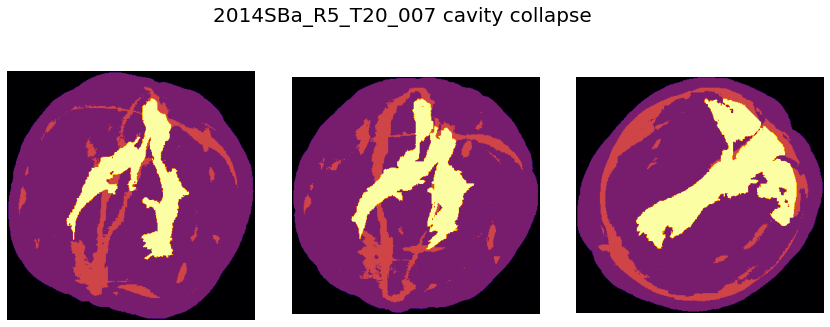

In [52]:
snaps = wnut.collapse_dimensions_max(test)
fig, ax = wnut.plot_collapse_dimensions(snaps, fname, 'cavity', dst=wdstp, writefig=False, display=True)
for i in range(len(ax)):
    ax[i].axis('off')
filename = wdstp + fname + '_cavity.jpg'
plt.savefig(filename, dpi=96, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight');

In [53]:
filename = wdst + fname + '_protrusion.tif'
filename
tf.imwrite(filename, test, photometric='minisblack', compress=3)